In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openbabel import pybel
from tqdm import tqdm


In [7]:
def sdf_load(uid, train=True):
    if train:
        path = os.path.join('data', 'train_sdf', f'train_{uid}.sdf')
    else:
        path = os.path.join('data', 'train_sdf', f'test_{uid}.sdf')
    return path

In [8]:
train_df = pd.read_csv(os.path.join('data', 'train.csv'))
train_df.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724


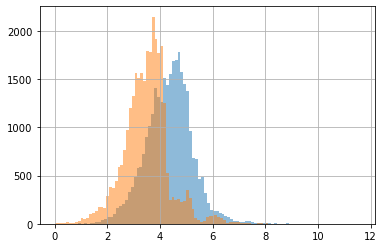

In [9]:
train_df['S1_energy(eV)'].hist(bins=100, alpha=0.5)
train_df['T1_energy(eV)'].hist(bins=100, alpha=0.5)
plt.show()

# Remove abnormal sdf files

In [10]:
mols = dict()

for n in tqdm(train_df.index):
    mol = [i for i in pybel.readfile('sdf', sdf_load(n))]
    if len(mol) > 0:
        mols[n] = mol[0]

100%|██████████| 30274/30274 [00:32<00:00, 920.32it/s]


In [11]:
set([i for i in range(train_df.shape[0])]) - set(mols.keys())

In [12]:
mols_df = pd.DataFrame().from_dict({n:v.calcdesc() for n, v in mols.items()}).transpose()
mols_df = mols_df.dropna(axis=1)
mols_df.loc[:,'uid'] = [f'train_{n}' for n in mols.keys()]

df = pd.merge(train_df, mols_df, 'outer', on='uid').dropna()
df['y'] = df['S1_energy(eV)'] - df['T1_energy(eV)']

df = df.reset_index(drop=True)
df.head()

,uid,SMILES,S1_energy(eV),T1_energy(eV),HBA1,HBA2,HBD,logP,MR,MW,nF,rotors,TPSA,y
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809,30.0,7.0,0.0,0.0,0.0,383.44090,0.0,7.0,0.0,1.2938
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585,36.0,8.0,2.0,0.0,0.0,597.12636,0.0,7.0,0.0,0.2032
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787,29.0,7.0,1.0,0.0,0.0,373.46922,0.0,7.0,0.0,0.4633
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847,23.0,4.0,2.0,0.0,0.0,252.37570,0.0,5.0,0.0,1.1054
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724,29.0,3.0,1.0,0.0,0.0,297.35695,3.0,9.0,0.0,0.2243


# Simple Random forest regression

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [14]:
train_x = df.iloc[:, 4:-1]
train_y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y)
RF = RandomForestRegressor()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print(f'MSE : {mean_squared_error(y_test, y_pred):.6}, R2 : {r2_score(y_test, y_pred):.6}')

MSE : 0.129241, R2 : 0.0176973


In [15]:
# MSE : 0.131453, R2 : 0.0139837